# Age Cross-Prediction

In [1]:
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme(
    context="paper", 
    style="whitegrid", 
    font_scale=1.2,
    rc={'figure.figsize': (10, 10), 'figure.dpi': 300}
)

## Get Data

In [2]:
from common.data import get_data

X, Y, demographics, population = get_data(wisc_level=5)
ages = demographics['Age']

print(f'X: {X.shape} | Y: {len(Y.keys())} | Age: {ages.shape} | Population: {population}')

X: (380, 34716) | Y: 6 | Age: (380,) | Population: adhd


In [3]:
from common.scoring import (unimetric_scorer, multimetric_scorer, 
                            custom_permutation_test_score, N_PERM, SCORING, RKF_10_10)
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import cross_validate, permutation_test_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

## Run for one target, one age bin

In [4]:
selected_target = "WISC_FSIQ"
y = Y[selected_target]

print(f'{selected_target}: {y.shape}')

WISC_FSIQ: (380,)


In [5]:
from common.binning import bin_by_age

bins = bin_by_age(X, y, ages, y)
bin_1, bin_2, bin_3 = bins[0], bins[1], bins[2]
bin_1_X, bin_1_y = bin_1[0], bin_1[1]
print(f'Bin 1: {bin_1[0].shape} | Bin 2: {bin_2[0].shape} | Bin 3: {bin_3[0].shape}')

Bin 1: (114, 34716) | Bin 2: (152, 34716) | Bin 3: (114, 34716)


### Set up the model pipeline, metrics, and cross-validation approach

In [27]:
%%time

estimators = [StandardScaler(), RidgeCV(alphas=[a for a in range(5000, 55000, 5000)], 
                                        scoring=unimetric_scorer, cv=RKF_10_10)]
pipe = make_pipeline(*estimators)
pipe.fit(X, y)
ridge_cv = pipe['ridgecv']
best_alpha = ridge_cv.alpha_

print(f'Target: {selected_target} | Alpha: {best_alpha} | Score: {ridge_cv.best_score_:.2f}')

Target: WISC_FSIQ | Alpha: 25000 | Score: 0.35
CPU times: user 1min 37s, sys: 2.03 s, total: 1min 39s
Wall time: 10 s


In [6]:
# From previous results
best_alpha = 15000

### Run cross-validation (train all, test bin)

In [23]:
%%time
bin_1_test, bin_2_test, bin_3_test = [], [], []
bin_test_scores = [bin_1_test, bin_2_test, bin_3_test]
bin_test_labels = ['Bin 1', 'Bin 2', 'Bin 3']
scoring = ['r', 'p_value', 'mse']

for bin_1_idx, bin_2_idx, bin_3_idx in zip(
    RKF_10_10.split(bin_1[0]), RKF_10_10.split(bin_2[0]), RKF_10_10.split(bin_3[0])):
    X_bin_1_train, X_bin_1_test = bin_1[0][bin_1_idx[0]], bin_1[0][bin_1_idx[1]]
    y_bin_1_train, y_bin_1_test = bin_1[1][bin_1_idx[0]], bin_1[1][bin_1_idx[1]]
    X_bin_2_train, X_bin_2_test = bin_2[0][bin_2_idx[0]], bin_2[0][bin_2_idx[1]]
    y_bin_2_train, y_bin_2_test = bin_2[1][bin_2_idx[0]], bin_2[1][bin_2_idx[1]]
    X_bin_3_train, X_bin_3_test = bin_3[0][bin_3_idx[0]], bin_3[0][bin_3_idx[1]]
    y_bin_3_train, y_bin_3_test = bin_3[1][bin_3_idx[0]], bin_3[1][bin_3_idx[1]]
    X_train = np.concatenate((X_bin_1_train, X_bin_2_train, X_bin_3_train))
    y_train = np.concatenate((y_bin_1_train, y_bin_2_train, y_bin_3_train))
#     print(X_train.shape, X_bin_1_test.shape, X_bin_2_test.shape, X_bin_3_test.shape)
    
#     pipe = make_pipeline(StandardScaler(), Ridge(alpha=best_alpha))
    pipe = make_pipeline(StandardScaler(), PLSRegression(n_components=4))
    pipe.fit(X_train, y_train)

    bin_1_test.append(multimetric_scorer(pipe, X_bin_1_test, y_bin_1_test))
    bin_2_test.append(multimetric_scorer(pipe, X_bin_2_test, y_bin_2_test))
    bin_3_test.append(multimetric_scorer(pipe, X_bin_3_test, y_bin_3_test))

for bin_label, bin_score in zip(bin_test_labels, bin_test_scores):
    for score in scoring:
        bin_scores = [s[score] for s in bin_score]
        print(f'{bin_label} Test {score}: {np.mean(bin_scores):.4f}')
    print('---')

Bin 1 Test r: 0.3837
Bin 1 Test p_value: 0.3111
Bin 1 Test mse: 222.9756
---
Bin 2 Test r: 0.3992
Bin 2 Test p_value: 0.2206
Bin 2 Test mse: 229.1058
---
Bin 3 Test r: 0.2666
Bin 3 Test p_value: 0.4215
Bin 3 Test mse: 292.5694
---
CPU times: user 15min 27s, sys: 1min 1s, total: 16min 28s
Wall time: 5min 44s


### Run cross-validation (train bin, test bin)

In [25]:
%%time
bin_1_test, bin_2_test, bin_3_test = [], [], []
bin_test_scores = [bin_1_test, bin_2_test, bin_3_test]
bin_test_labels = ['Bin 1', 'Bin 2', 'Bin 3']
scoring = ['r', 'p_value', 'mse']

selected_bin = bin_2
coefs = []

for bin_idx in RKF_10_10.split(selected_bin[0]):
    X_train, X_test = selected_bin[0][bin_idx[0]], selected_bin[0][bin_idx[1]]
    y_train, y_test = selected_bin[1][bin_idx[0]], selected_bin[1][bin_idx[1]]

    pipe = make_pipeline(StandardScaler(), PLSRegression(n_components=4))
    pipe.fit(X_train, y_train)
    coefs.append(pipe['plsregression'].coef_)

    bin_1_test.append(multimetric_scorer(pipe, bin_1[0], bin_1[1]))
    bin_2_test.append(multimetric_scorer(pipe, X_test, y_test))
    bin_3_test.append(multimetric_scorer(pipe, bin_3[0], bin_3[1]))

for bin_label, bin_score in zip(bin_test_labels, bin_test_scores):
    for score in scoring:
        bin_scores = [s[score] for s in bin_score]
        print(f'{bin_label} Test {score}: {np.mean(bin_scores):.4f}')
    print('---')

Bin 1 Test r: 0.3756
Bin 1 Test p_value: 0.0001
Bin 1 Test mse: 223.8976
---
Bin 2 Test r: 0.3972
Bin 2 Test p_value: 0.2617
Bin 2 Test mse: 224.1462
---
Bin 3 Test r: 0.2574
Bin 3 Test p_value: 0.0072
Bin 3 Test mse: 286.2837
---
CPU times: user 12min 27s, sys: 40.9 s, total: 13min 7s
Wall time: 3min 12s


### Run permutation-test (train bin, test bin)

In [13]:
%%time
bin_scores = [[], [], []]
bin_labels = ['Bin 1', 'Bin 2', 'Bin 3']

selected_bin = bin_1
coefs = []

for bin_1_idx, bin_2_idx, bin_3_idx in zip(
    RKF_10_10.split(bin_1[0]), RKF_10_10.split(bin_2[0]), RKF_10_10.split(bin_3[0])):

for bin_idx in RKF_10_10.split(selected_bin[0]):
    X_train, X_test = selected_bin[0][bin_idx[0]], selected_bin[0][bin_idx[1]]
    y_train, y_test = selected_bin[1][bin_idx[0]], selected_bin[1][bin_idx[1]]

    pipe = make_pipeline(StandardScaler(), PLSRegression(n_components=4))
    pipe.fit(X_train, y_train)
    coefs.append(pipe['plsregression'].coef_)

    bin_scores[0].append(custom_permutation_test_score(
        pipe, bin_1[0], bin_1[1], N_PERM, scorer=unimetric_scorer))
    bin_scores[1].append(custom_permutation_test_score(
        pipe, X_test, y_test, N_PERM, scorer=unimetric_scorer))
    bin_scores[2].append(custom_permutation_test_score(
        pipe, bin_3[0], bin_3[1], N_PERM, scorer=unimetric_scorer))

for bin_label, bin_score in zip(bin_test_labels, bin_test_scores):
    bin_scores = [s[0] for s in bin_score]
    bin_pvalues = [s[2] for s in bin_score]
    
    print(f'{bin_label} Test r: {np.mean(bin_scores):.4f}')
    print(f'{bin_label} Test p_value: {np.mean(bin_pvalues):.4f}')
    print('---')

Bin 1 Test r: 0.0929
Bin 1 Test p_value: 0.1860
---
Bin 2 Test r: 0.0713
Bin 2 Test p_value: 0.4143
---
Bin 3 Test r: 0.0839
Bin 3 Test p_value: 0.1973
---
CPU times: user 1h 52min 37s, sys: 3min 33s, total: 1h 56min 10s
Wall time: 11min 37s


3 3


/home/bpho/.conda/envs/venv/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 78.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Cross Validation Results (Bin 1 -> Each Bin)')

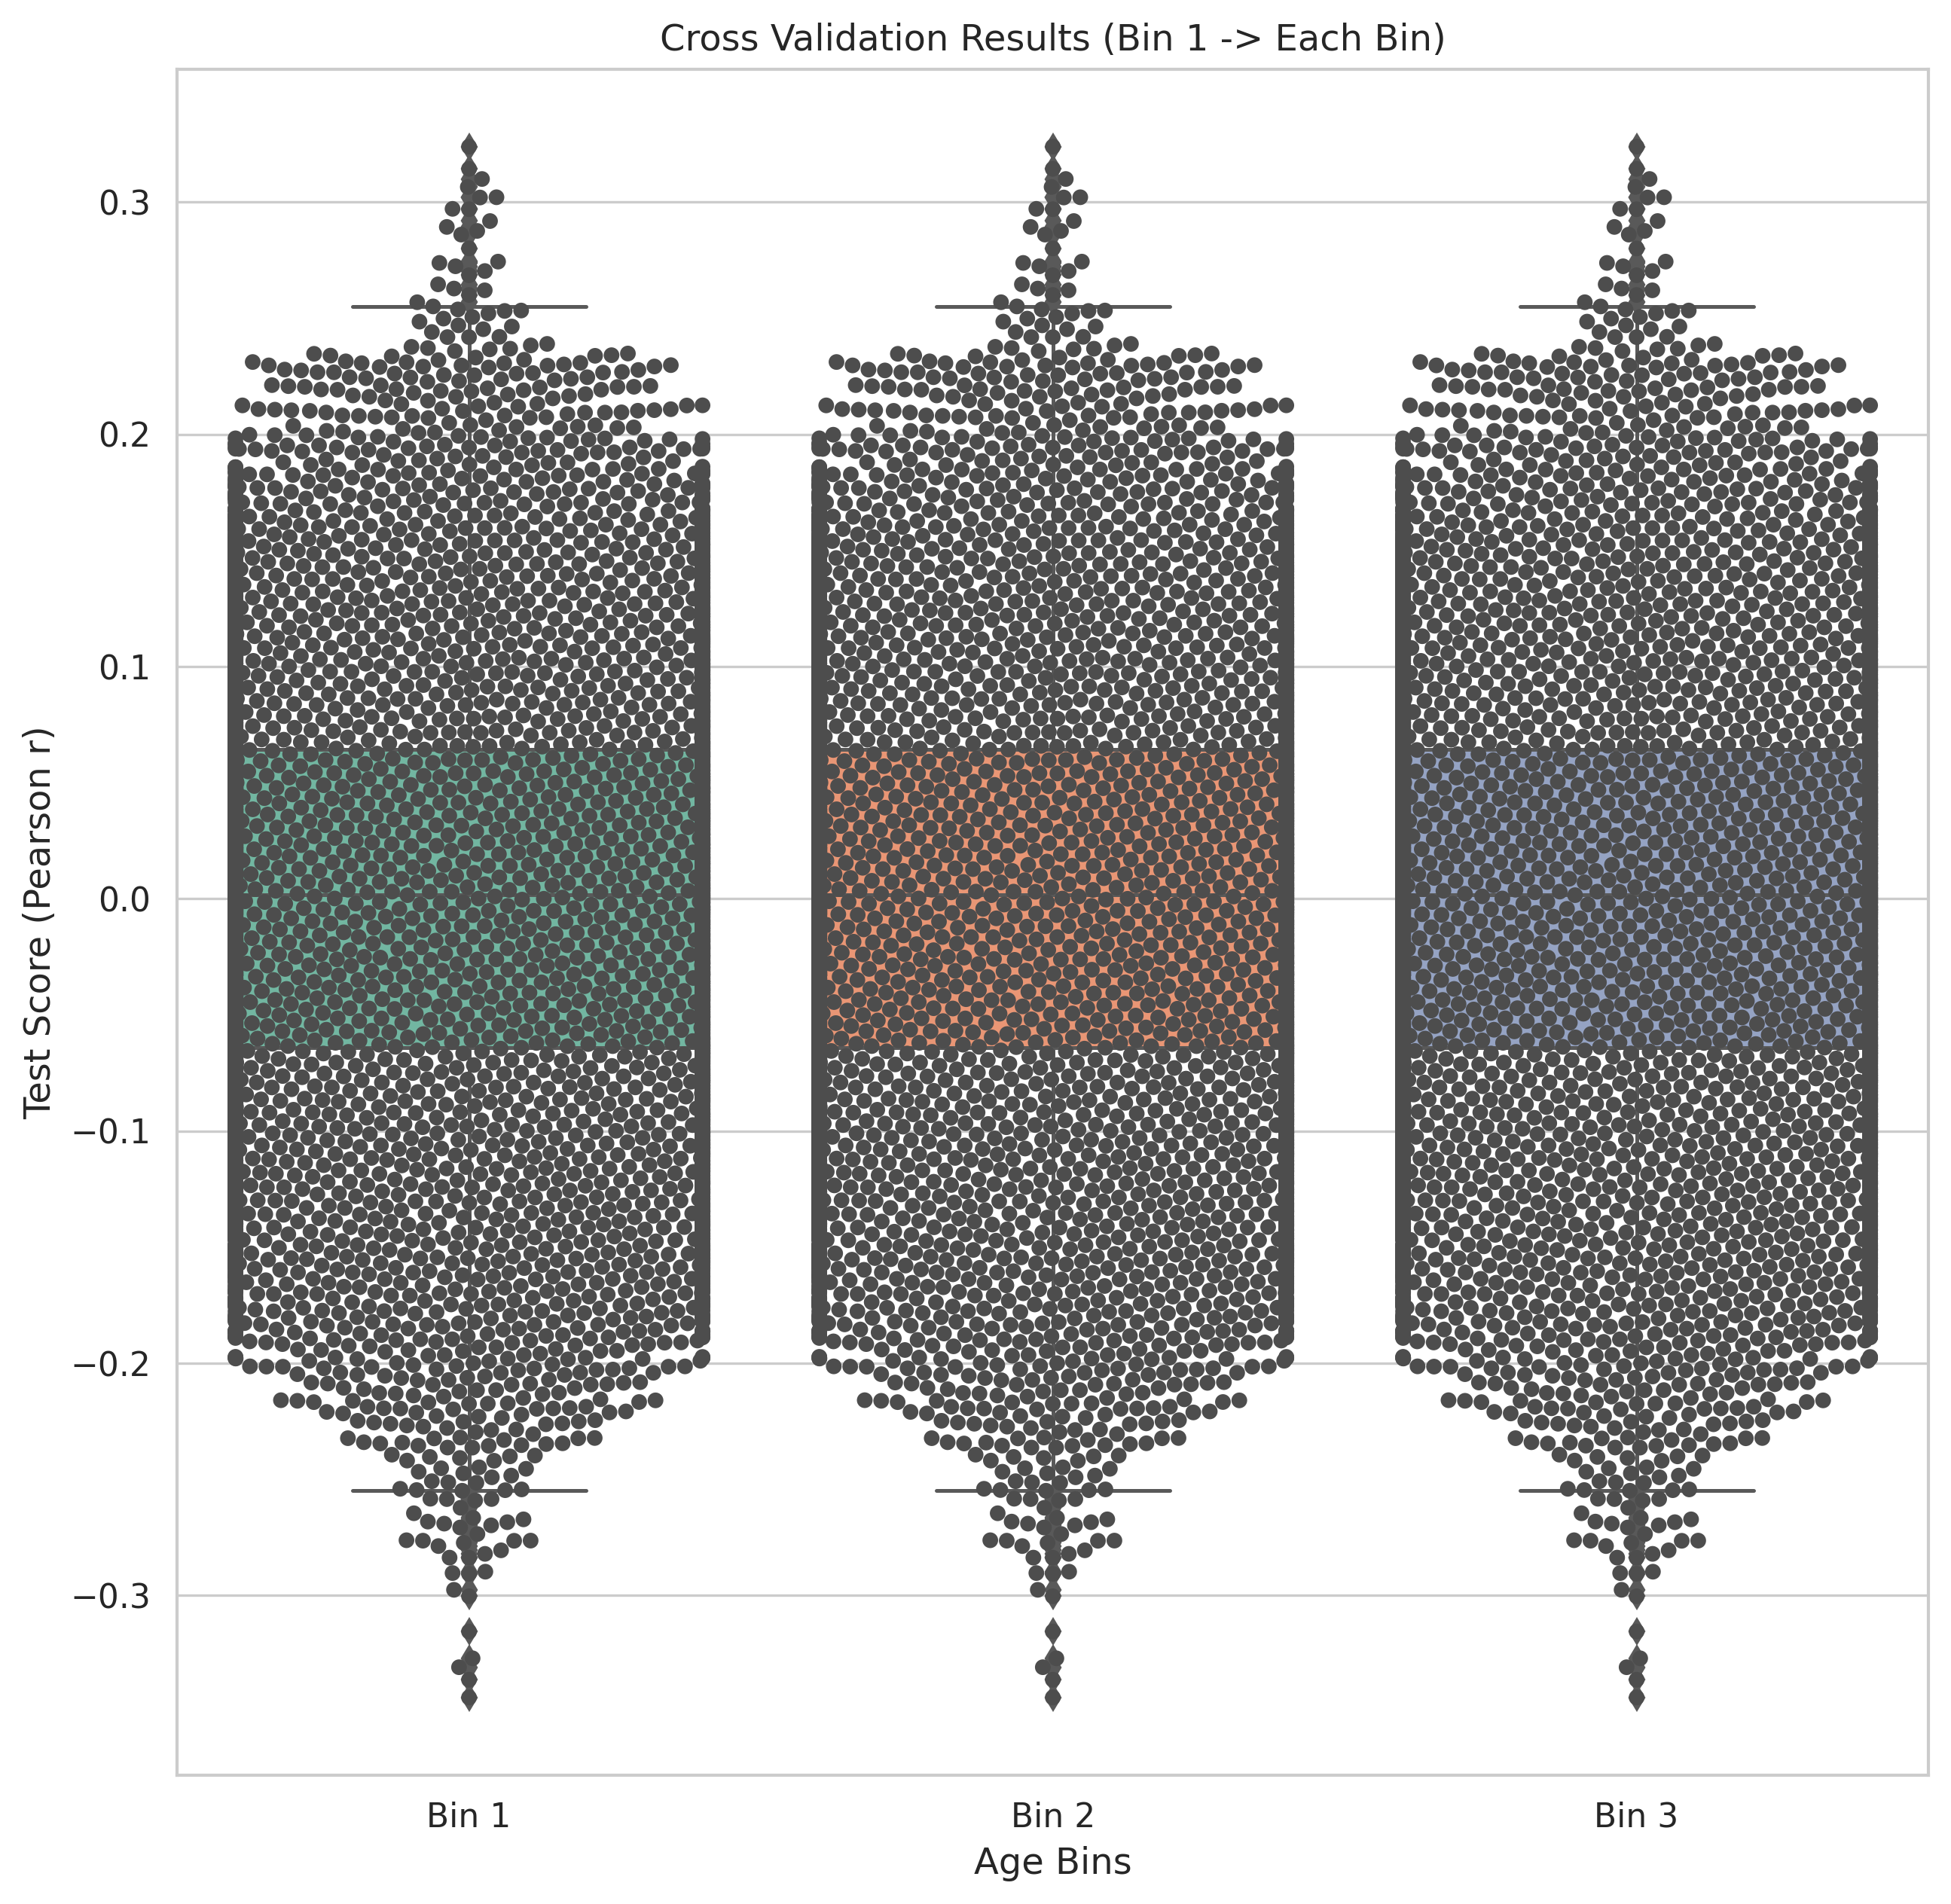

In [28]:
display_scores = []
# for bin_score in bin_test_scores:
#     display_scores.append([s['p_value'] for s in bin_score])
for _ in bin_test_labels:
    temp = []
    temp.append([s[1] for s in bin_score])
    temp = np.array(temp).flatten()
    display_scores.append(temp)

# print(len(bin_test_labels), len(display_scores))
results = pd.DataFrame(dict(zip(bin_test_labels, display_scores)))

ax = sns.boxplot(data=results, palette="Set2")
ax = sns.swarmplot(data=results, color="0.3", order=bin_test_labels)
ax.set_ylabel('Test Score (Pearson r)')
ax.set_xlabel('Age Bins')
ax.set_title('Cross Validation Results (Bin 1 -> Each Bin)')

In [19]:
bin_1_coefs = coefs.copy()

In [26]:
bin_2_coefs = coefs.copy()

In [24]:
bin_3_coefs = coefs.copy()

### ICC

In [29]:
%%time
import pingouin as pg

group_one = pd.DataFrame(np.squeeze(np.array(bin_2_coefs), axis=2))
group_one['group'] = 'g1'

group_two = pd.DataFrame(np.squeeze(np.array(bin_3_coefs), axis=2))
group_two['group'] = 'g2'

group_one_two = pd.concat([group_one, group_two])
icc_data = pd.melt(group_one_two, id_vars='group', var_name='connection', 
                   value_name='weight', ignore_index=False)
# display(icc_data)

icc = pg.intraclass_corr(data=icc_data, targets='connection', raters='group', ratings='weight').round(3)
icc.set_index("Type")

CPU times: user 2min 2s, sys: 1.52 s, total: 2min 3s
Wall time: 2min 13s


,Description,ICC,F,df1,df2,pval,CI95%
Type,,,,,,,
ICC1,Single raters absolute,0.111,1.249,34715,34716,0.0,"[0.1, 0.12]"
ICC2,Single random raters,0.111,1.249,34715,34715,0.0,"[0.1, 0.12]"
ICC3,Single fixed raters,0.111,1.249,34715,34715,0.0,"[0.1, 0.12]"
ICC1k,Average raters absolute,0.200,1.249,34715,34716,0.0,"[0.18, 0.22]"
ICC2k,Average random raters,0.199,1.249,34715,34715,0.0,"[0.18, 0.22]"
ICC3k,Average fixed raters,0.199,1.249,34715,34715,0.0,"[0.18, 0.22]"
